In [1]:
from code.organize import *

from code.roughEDA import *

import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
df = pd.read_excel('data/employment/GSS.xls')

In [3]:
variables = extract_variables('data/employment/GSS.sps')

In [4]:
replace_variables(df,variables)

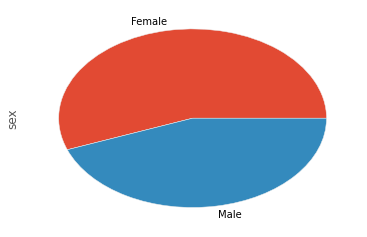

In [5]:
pd.Series(df.sex.value_counts()).plot(kind = 'pie')

In [ ]:
df3.shape

In [ ]:
df3 = df3.sort(['year','id_']).drop_duplicates(['year','id_'])

In [ ]:
df1.drop_duplicates(['year','id_']).shape

In [ ]:
temp = pd.crosstab(df.wrkstat,df.sex,dropna=False)
temp

In [ ]:
import six
from matplotlib import colors
import random

In [ ]:
df.columns

In [ ]:
simple_bar(df.marital)

In [ ]:
stack_bar(df.happy,df.teens)

In [ ]:
temp.plot(kind = 'pie',subplots=True,figsize=(20,8),autopct='%.2f');

#plt.legend(loc = (0.5, 0), ncol=5)

In [ ]:
h_bar(df.wrkstat,df.happy)

In [ ]:
temp.plot(kind = 'barh',figsize=(8,8))

In [ ]:
simple_bar(df.wrkstat, size = (20,10))

In [ ]:
pie_chart(df.wrkstat,df.marital,(20,20))

In [ ]:
h_bar(df.wrkstat,df.marital,(20,20))